**NOTE:** This notebook has the code that has been used to simulate the new demographics function added as a way to specify the age of the population according to some real place. In this case, the county of Greene (Missouri).

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Current Age Generation Function

(array([ 974., 2002., 2167., 1888., 1354.,  836.,  490.,  211.,   62.,
          16.]),
 array([ 0. ,  8.9, 17.8, 26.7, 35.6, 44.5, 53.4, 62.3, 71.2, 80.1, 89. ]),
 <BarContainer object of 10 artists>)

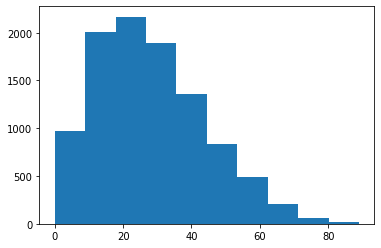

In [2]:
age_list = []
for n in np.arange(10000):
    age = int(np.random.beta(2, 5, 1) * 100)
    age_list.append(age)
plt.hist(age_list)

## New Roulette Age Selection

In [10]:
# percent of people with age <= key
greene_demographics = {
    'age_distribution':{
        4: 6.0,
        9: 5.7,
        14: 5.8,
        19: 6.5,
        24: 10.6,
        34: 14.1,
        44: 11.7,
        54: 11.5,
        59: 6.0,
        64: 6.0,
        74: 8.9,
        84: 5.0,
        100: 2.1
    },
    #'work_classes':{
    #    'Retail': 12.7,
    #}
}

# # percent of people with age <= key
# greene_demographics = {
#     'age':{
#         54: 50.0,
#         100: 50.0
#     },
#     #'work_classes':{
#     #    'Retail': 12.7,
#     #}
# }


greene_population = 293086

In [14]:
class Demographics:
    def __init__(self, demographics_dict):
        allowed_keys = ['age_distribution']
        assert all([key in allowed_keys for key in demographics_dict.keys()]), "Demographics dictionary keys ({}) should be contained in {}.".format(list(demographics_dict.keys()), allowed_keys)
        
        self.age_roulette = None
        if 'age_distribution' in demographics_dict.keys():
            self.age_distribution = demographics_dict['age_distribution']
            self.age_roulette = self.convert_age_dict(self.age_distribution)
    
    def convert_age_dict(self, age_dict):
        MAXIMUM_ALLOWED_AGE = 100
        ages = list(age_dict.keys())
        weights = list(age_dict.values())
        assert min(ages) >= 1, "Minimum expected age is 1"
        assert max(ages) <= MAXIMUM_ALLOWED_AGE, "Maximum expected age is {}".format(MAXIMUM_ALLOWED_AGE)

        all_ages = []
        all_weights = []
        for i, age in enumerate(ages):
            if i == 0:
                repeated_age = list(range(1,age+1))
                repeated_weight = [weights[i]]*len(repeated_age)
                all_ages += repeated_age
                all_weights += repeated_weight
            else:
                repeated_age = list(range(ages[i-1]+1,age+1))
                repeated_weight = [weights[i]]*len(repeated_age)
                all_ages += repeated_age
                all_weights += repeated_weight
        assert len(all_weights) == MAXIMUM_ALLOWED_AGE
        return all_ages, all_weights

In [15]:
demo = Demographics(greene_demographics)

#### Testing roulette selection

In [16]:
from model.base import roulette_selection

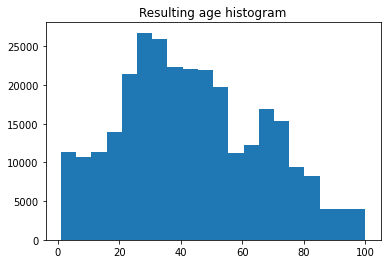

In [17]:
all_ages = []
for n in range(greene_population):
    all_ages.append(roulette_selection(demo.age_roulette[0], demo.age_roulette[1]))

plt.hist(all_ages, bins=20);
plt.title('Resulting age histogram');

In [20]:
age_range_array = np.array([0] + list(greene_demographics['age_distribution'].keys()))
age_percents = {}
for i, age in enumerate(age_range_array):
    if i == 0:
        continue
    age_percents[age] = 100 * np.sum(np.logical_and(all_ages > age_range_array[i-1], all_ages <= age_range_array[i])) / greene_population

In [21]:
age_percents

{4: 3.1482227059634376,
 9: 3.636475300764963,
 14: 3.769883242461257,
 19: 4.19126126802372,
 24: 6.879891908859515,
 34: 18.322949577939582,
 44: 15.145042751956764,
 54: 14.94714861849423,
 59: 3.8425581569914633,
 64: 3.8548412411374136,
 74: 11.474106576226774,
 84: 6.421664630859202,
 100: 4.365954020321681}

In [24]:
greene_demographics['age_distribution']

{4: 6.0,
 9: 5.7,
 14: 5.8,
 19: 6.5,
 24: 10.6,
 34: 14.1,
 44: 11.7,
 54: 11.5,
 59: 6.0,
 64: 6.0,
 74: 8.9,
 84: 5.0,
 100: 2.1}

In [25]:
sum(age_percents.values())

99.99999999999999

In [27]:
np.array(list(age_percents.values())) - np.array(list(greene_demographics['age_distribution'].values()))

array([-2.85177729, -2.0635247 , -2.03011676, -2.30873873, -3.72010809,
        4.22294958,  3.44504275,  3.44714862, -2.15744184, -2.14515876,
        2.57410658,  1.42166463,  2.26595402])

#### Creating roulette

In [30]:
#def demographics_roulette(values, weights, total_population):

values = np.array(list(greene_demographics['age_distribution'].keys()))
weights = list(greene_demographics['age_distribution'].values())

total_value = sum(weights)
cumsum_weights = np.cumsum(weights)
cumsum_weights


array([ 6. , 11.7, 17.5, 24. , 34.6, 48.7, 60.4, 71.9, 77.9, 83.9, 92.8,
       97.8, 99.9])

In [31]:
random_number = np.random.random() * total_value

print(random_number)
print(values)
print(cumsum_weights)
print(cumsum_weights <= random_number)
print(values[cumsum_weights <= random_number])

lower_age_range = values[cumsum_weights <= random_number][-1]
print(lower_age_range)

11.883500742770002
[  4   9  14  19  24  34  44  54  59  64  74  84 100]
[ 6.  11.7 17.5 24.  34.6 48.7 60.4 71.9 77.9 83.9 92.8 97.8 99.9]
[ True  True False False False False False False False False False False
 False]
[4 9]
9


In [32]:
lower_idx = list(values).index(lower_age_range)
higher_age_range = values[lower_idx + 1]
print(higher_age_range)

14


## New Approach

In [33]:
greene_population

293086

In [34]:
greene_demographics['age_distribution']

{4: 6.0,
 9: 5.7,
 14: 5.8,
 19: 6.5,
 24: 10.6,
 34: 14.1,
 44: 11.7,
 54: 11.5,
 59: 6.0,
 64: 6.0,
 74: 8.9,
 84: 5.0,
 100: 2.1}

In [35]:
total_population = greene_population
age_dict = greene_demographics['age_distribution']
# -----------
# Calculates the number of agents in each age range using given weights
weight_array = np.array(list(age_dict.values())) 
percent_array = weight_array / np.sum(weight_array)
agents_by_age_range = []
for p in percent_array:
    agents_by_age_range.append(int(p * total_population))
population = sum(agents_by_age_range)

# Fixes rounding errors by changing the highest number only
agents_by_age_range[agents_by_age_range.index(max(agents_by_age_range))] += total_population - population 
population = sum(agents_by_age_range)
assert population == total_population

# Gets random ages for each age range according to their respective number of agents
age_range_array = np.array([0] + list(age_dict.keys()))
agent_ages_by_range = []
for i, age in enumerate(age_range_array):
    if i == 0:
        continue
    agent_ages_by_range.append(np.random.randint(low = age_range_array[i-1]+1,
                                                  high = age_range_array[i]+1,
                                                  size = agents_by_age_range[i-1]))
all_agent_ages = np.concatenate(agent_ages_by_range)
assert len(all_agent_ages) == total_population

### Testing proportions

In [44]:
age_range_array = np.array([0] + list(greene_demographics['age_distribution'].keys()))
age_percents = {}
for i, age in enumerate(age_range_array):
    if i == 0:
        continue
    age_percents[age] = np.round(100 * np.sum(np.logical_and(all_agent_ages > age_range_array[i-1], all_agent_ages <= age_range_array[i])) / total_population, 1)
age_percents

{4: 6.0,
 9: 5.7,
 14: 5.8,
 19: 6.5,
 24: 10.6,
 34: 14.1,
 44: 11.7,
 54: 11.5,
 59: 6.0,
 64: 6.0,
 74: 8.9,
 84: 5.0,
 100: 2.1}

In [45]:
greene_demographics['age_distribution']

{4: 6.0,
 9: 5.7,
 14: 5.8,
 19: 6.5,
 24: 10.6,
 34: 14.1,
 44: 11.7,
 54: 11.5,
 59: 6.0,
 64: 6.0,
 74: 8.9,
 84: 5.0,
 100: 2.1}

### Assembling class

In [46]:
class Demographics:
    def __init__(self, demographics_dict):
        allowed_keys = ['total_population', 'age_distribution']
        assert all([key in allowed_keys for key in demographics_dict.keys()]), "Demographics dictionary keys ({}) should be contained in {}.".format(list(demographics_dict.keys()), allowed_keys)
        
        self.demographics_dict = demographics_dict
        self.agent_ages = None
        self.total_population = None
        if 'age_distribution' in demographics_dict.keys():
            assert 'total_population' in demographics_dict.keys(), "Total population is necessary to do age calculations"
            self.total_population = demographics_dict['total_population']
            self.agent_ages = self.convert_age_dict(demographics_dict['age_distribution'])
    
    def convert_age_dict(self, age_dict):
        
        # Calculates the number of agents in each age range using given weights
        weight_array = np.array(list(age_dict.values())) 
        percent_array = weight_array / np.sum(weight_array)
        agents_by_age_range = []
        for p in percent_array:
            agents_by_age_range.append(int(p * self.total_population))
        population = sum(agents_by_age_range)

        # Fixes rounding errors by changing the highest number only
        agents_by_age_range[agents_by_age_range.index(max(agents_by_age_range))] += self.total_population - population 
        population = sum(agents_by_age_range)
        assert population == self.total_population

        # Gets random ages for each age range according to their respective number of agents
        age_range_array = np.array([0] + list(age_dict.keys()))
        agent_ages_by_range = []
        for i, age in enumerate(age_range_array):
            if i == 0:
                continue
            agent_ages_by_range.append(np.random.randint(low = age_range_array[i-1]+1,
                                                          high = age_range_array[i]+1,
                                                          size = agents_by_age_range[i-1]))
        all_agent_ages = np.concatenate(agent_ages_by_range)
        assert len(all_agent_ages) == self.total_population
        return all_agent_ages

In [47]:
# percent of people with age <= key
greene_demographics = {
    'total_population': 293086,
    'age_distribution':{
        4: 6.0,
        9: 5.7,
        14: 5.8,
        19: 6.5,
        24: 10.6,
        34: 14.1,
        44: 11.7,
        54: 11.5,
        59: 6.0,
        64: 6.0,
        74: 8.9,
        84: 5.0,
        100: 2.1
    },
    #'work_classes':{
    #    'Retail': 12.7,
    #}
}

demo = Demographics(greene_demographics)

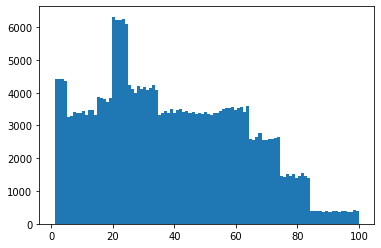

In [48]:
plt.hist(demo.agent_ages, bins=100);